# Fine-Grained Classification Using ConvNeXt

![gif](https://media.tenor.com/zBdbio-Y0HUAAAAd/monkey-keyboard.gif)

*By Petrov as a hacker, 193*

## Abstract

<!-- https://habr.com/ru/company/otus/blog/654279/
https://www.youtube.com/watch?v=QqejV0LNDHA -->

*- Мы постепенно “модернизируем” стандартную сеть ResNet в направлении разработки трансформера и обнаруживаем несколько ключевых компонентов, которые способствуют повышению производительности на этом пути.*

Что будет, если мы уменьшим прожорливость сверточных сетей, используя все трюки из трансформеров и со всеми улучшениями в регуляризации, аугментации и оптимизации? Получится ConvNeXt.

Сверточные сети могут переиграть трансформеров, используя улучшенные техники. Авторы разделили их на 5 блоков:
* Макродизайн
* ResNeXt
* Inverted Bottleneck
* Увеличенный размер ядра
* Микродизайн

## Обучение

* Обучение: 300 эпох вместо 90, AdamW вместо Adam/SGD
* Аугментации: Mixup, Cutmix, RandAugment (продвинутые, которых не было на момент выхода ResNet); Random
Erasing.
* Регуляризация: стохастическая глубина (stochastic depth) -- как дропаут ко всему блоку, а не просто к слою; сглаживание метки (label smoothing) -- ввод мягких таргетов как средневзвешенное между жесткими таргетами, что помогает увеличить разделение классов.

## Макродизайн

* **Stage compute ratio.** Соотношение чисел повторения блоков на каждой стадии. В ResNet -- 3:4:6:3, в Swin -- 1:1:3:1. Точно такое соотношение и перевели в ResNet
* **Changing stem to "Patchify".** На адекватном языке это означает изменение дизайна начального блока свертки со стандартной свертки (7x7 + `MaxPool(4)` с шагом 2) на блок патчификации, подобно ViT (неперекрывающаяся свертка 4x4, `stride=4`)

## ResNeXt-ify

Идея заимствуется у ResNeXt, где основным компонентом является сгруппированная свертка, где сверточные фильтры разделены на разные группы. Это позволяет уменьшаться FLOPs путем уменьшения числа входных и выходных каналов, а потеря мощности модели компенсируется количеством параллельных блоков.

![](https://miro.medium.com/max/1400/1*LOoc11tkDoqv0pC6OH7mwA.png)

Работа использует свертку по глубине (depthwise), с количеством групп равным числу входных каналов, поэтому каждое ядро свертки обрабатывает один канал и смешивает информацию только в пространственном измерении, чтобы получить эффект, подобный механизму внутреннего внимания (self-attention).

![](https://www.researchgate.net/publication/358585116/figure/fig1/AS:1127546112487425@1645839350616/Depthwise-separable-convolutions.png)

Ширина (число групп) увеличена с 64 до 94 как в Swin-T.

## Inverted Bottleneck

Заимствуется идея из общей архитектуры трансформера, в bottleneck-слое которого ширина скрытого полносвязаного слоя (посередине) должна быть в как минимум в 4 раза больше входного. Так как ширина было увеличена до 96, то в bottleneck-слой выглядит как 96-384-96.

![bottleneck.png](https://habrastorage.org/r/w1560/getpro/habr/upload_files/7ad/1a4/c4d/7ad1a4c4dcd8a82b08b9ea01845a4439.png)

* (a) ResNeXt block
* (b) inverted bottleneck block
* In (c) the position of the spatial depthwise conv layer is moved up

Хотя FLOPs глубокого сверточного слоя увеличивается после такого реверса, FLOPs всей сети падает из-за эффекта даунсэмплинга (понижения размерности feature map) остаточного блока.

## Большие свертки

Перемечение блока глубокой свертки 3x3 наверх (см. рис (b) ⟶ (c)) позволило применять большие свертки размера 7x7 как в трансформерах, что в конечном итоге позволило увеличить `accuracy`. 

## Микродизайн

См. на рисунке ниже. Все как в трансформерах: GELU вместо ReLU (BERT, GPT-2, ViTs); меньше активаций (1 GELU в каждом блоке); уменьшение BatchNorm-слоев (остается только один перед свертками ядра 1x1); замена BN на LN; вводится разделительный downsampling слой по аналогии с Swin (там такие слови между stage'ами).


![](https://habrastorage.org/r/w1560/getpro/habr/upload_files/338/29f/38d/33829f38d1dc9ab9a6d5afaee16ce0cb.png)

![](https://images.velog.io/images/cgotjh/post/4ec3c7d2-79b5-4ebd-8b1f-59f3a6a56c77/image.png)

Стоит отметить, что все варианты решения, обсуждавшиеся до сих пор, адаптированы из ViTs. Кроме того, они не являются новыми даже в литературе ConvNet — все они были исследованы отдельно, но не коллективно, за последнее десятилетие.

ConvNeXt примерно сопоставима с Swin Transformer во всех масштабах с точки зрения количества параметров, пропускной способности и использования памяти. Преимущество ConvNeXt в том, что она не требует дополнительных структур, таких как включение механизмов внимания к смещению окна, сдвига относительного позиционирования и так далее, т.е. проще в устройсте.

# Fine-Grained Classification
Посмотрим, как работает модель на задаче классификации трудноразличимых объектов.

In [ ]:
import torch
import numpy as np

# Higher-level API:
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
import time
import os
from IPython.display import clear_output
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import random
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_random_seed(10)

In [1]:
!pip install -q timm

     |████████████████████████████████| 548 kB 7.6 MB/s 
     |████████████████████████████████| 163 kB 62.1 MB/s 


In [2]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

In [3]:
import timm
from timm import create_model
# https://pypi.org/project/timm/

## Data Transforms & Augs

Dataset: StanfordCars | Fine-Grained Image Classification.

Используем стандартные аугментации.

In [ ]:
base_transforms = [
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

train_transform = transforms.Compose([*base_transforms[:2],
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(20),
                                     *base_transforms[2:]
                                ])

valid_transform = transforms.Compose(base_transforms)

In [ ]:
from torchvision.datasets import StanfordCars

try:
    os.mkdir('data')
except:
    pass

train_dataset = StanfordCars(root='data', split='train', download=True, transform=train_transform)
valid_dataset = StanfordCars(root='data', split='test',  download=True, transform=valid_transform)
clear_output()

In [ ]:
BATCH_SIZE = 512

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

dataloaders = { 'train': train_loader, 'valid': valid_loader }
dataset_sizes = { 'train': len(train_dataset), 'valid': len(valid_dataset) }

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (12, 8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    plt.show()


def imshow_base(inputs, classes):
    out = torchvision.utils.make_grid(inputs[:8])
    imshow(out, title=classes[:8].tolist())

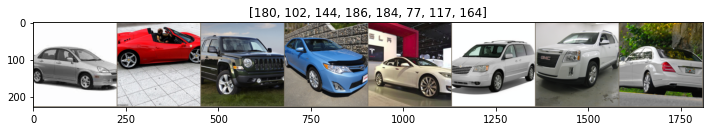

In [ ]:
inputs, classes = next(iter(valid_loader))
imshow_base(inputs, classes)

## Functions

In [ ]:
def plot_dynamics(losses_dict, loss_epoch,
                  accuracies_dict, accuracy_epoch,
                  steps_list, epoch_num, figsize=(14, 10)):
    '''
        losses_dict[train]: loss per batch at train
        losses_dict[valid]: mean loss per train steps
        accuracies_dict[train]: accuracy per batch at train
        accuracies_dict[valid]: mean accuracy per train steps

        loss_epoch[phase]: epochs losses on phase
        accuracy_epoch[phase]: epochs accuracies on phase

        steps_list: cumulative sum list of train_steps
        epoch_num: number of running epoch > 0
    '''

    ncols = 1 if epoch_num == 1 else 2
    if epoch_num == 1:
        figsize = (figsize[1] // 2 + 1, figsize[1])
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=figsize, squeeze=False)

    axes[0][0].plot(losses_dict['train'], label='train', linewidth=2, c='royalblue', zorder=1)
    axes[0][0].scatter(steps_list, losses_dict['valid'], label='mean valid', linewidth=3, marker='+', s=200, c='orange', zorder=2)

    axes[1][0].plot(accuracies_dict['train'], label='train', linewidth=2, c='royalblue', zorder=1)
    axes[1][0].scatter(steps_list, accuracies_dict['valid'], label='mean valid', linewidth=3, marker='+', s=200, c='orange', zorder=2)

    if epoch_num != 1:
        for phase, c in [('train', 'royalblue'), ('valid', 'orange')]:
            axes[0][1].plot(loss_epoch[phase], label=phase, linewidth=2, c=c)
            axes[1][1].plot(accuracy_epoch[phase], label=phase, linewidth=2, c=c)
        axes[1][1].set_xlabel('epoch')
        axes[0][1].set_title('Loss dynamics for {} epochs'.format(epoch_num))
        axes[1][1].set_title('Accuracy dynamics for {} epochs'.format(epoch_num))

    axes[1][0].set_xlabel('train steps')
    axes[0][0].set_ylabel('Loss')
    axes[1][0].set_ylabel('Accuracy')
    axes[0][0].set_title('Loss at {} epoch'.format(epoch_num))
    axes[1][0].set_title('Accuracy at {} epoch'.format(epoch_num))

    for i in [0, 1]:
        js = [0, 1] if epoch_num > 1 else [0]
        for j in js:
            axes[i][j].grid()
            axes[i][j].legend()
    plt.show()

In [ ]:
import copy
from tqdm import tqdm
import time

def train_epoch(model, criterion, optimizer, scheduler=None, device='cpu', best_acc=0.0, use_amp=True, scaler=None, mix_fn=None):
    losses_dict =     { 'train': [], 'valid': [] }
    accuracies_dict = { 'train': [], 'valid': [] }
    loss_epoch =      { 'train': None, 'valid': None }
    accuracy_epoch =  { 'train': None, 'valid': None }
    best_model_wts = copy.deepcopy(model.state_dict())

    for phase in ['train', 'valid']:
        since = time.time()
        print(f'\nPhase: {phase} running')
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_metric = 0

        for inputs, labels in dataloaders[phase]:
            if phase == 'train' and mix_fn is not None:
                inputs, labels = mix_fn(inputs, labels)
                labels = labels.argmax(dim=-1)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):

                with torch.autocast(device_type = device.type
                                    if type(device) == torch.device else device,
                                    dtype=torch.float16, enabled=use_amp):
                    outputs = model(inputs)
                    probs = F.log_softmax(outputs, dim=-1)
                    preds = probs.argmax(dim=-1).to('cpu')
                    loss = criterion(probs, labels) # NLLLoss
                    labels = labels.to('cpu')

                if phase == 'train':
                    if scaler is not None:
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        loss.backward()
                        optimizer.step()

            # statistics
            loss_value = loss.item()
            accuracy_value = torch.sum(preds == labels.data) / len(preds)
            running_loss += loss_value * inputs.size(0)
            running_metric += accuracy_value * len(preds)

            losses_dict[phase].append(loss_value)
            accuracies_dict[phase].append(accuracy_value)
                
        if phase == 'train' and scheduler is not None:
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_metric.double() / dataset_sizes[phase]
        print(f'{phase} loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        loss_epoch[phase] = epoch_loss
        accuracy_epoch[phase] = epoch_acc

        # deep copy the model
        if phase == 'valid':
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print(f'Done in {time_elapsed / 50:.4f} m')

    losses_dict['valid'] = np.mean(losses_dict['valid'])
    accuracies_dict['valid'] = np.mean(accuracies_dict['valid'])
    return best_model_wts, best_acc, losses_dict, loss_epoch, accuracies_dict, accuracy_epoch

In [ ]:
from IPython.display import clear_output

def train(model, criterion, optimizer, scheduler=None, num_epochs=25, device='cpu', use_amp=True, use_scaler=False, mix_fn=None, saveto=None):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc_overall =        0.0
    train_steps =     []
    loss_steps =      { 'train': [], 'valid': [] }
    accuracy_steps =  { 'train': [], 'valid': [] }
    loss_epochs =     { 'train': [], 'valid': [] }
    accuracy_epochs = { 'train': [], 'valid': [] }

    # Mixed presicion training: https://github.com/NVIDIA/apex/issues/818
    # https://pytorch.org/docs/stable/notes/amp_examples.html
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp) if use_scaler else None

    model_name = model.__class__.__name__

    for epoch in tqdm(range(num_epochs), 'epoch'):
        tracking = train_epoch(model, criterion, optimizer, scheduler, device=device,
                               best_acc=best_acc_overall, use_amp=use_amp, scaler=scaler, mix_fn=mix_fn)
        best_model_wts, best_acc_epoch = tracking[0], tracking[1]
        losses_dict, loss_epoch = tracking[2], tracking[3]
        accuracies_dict, accuracy_epoch = tracking[4], tracking[5]

        if best_acc_epoch > best_acc_overall:
            best_acc_overall = best_acc_epoch
            if saveto is not None:
                _ = model_name + '-' + str(num_epochs) + '.pth'
                print('Saved as', _)
                torch.save(model.state_dict(), saveto +  _)

        loss_steps['train'].extend(losses_dict['train'])
        loss_steps['valid'].append(losses_dict['valid'])
    
        accuracy_steps['train'].extend(accuracies_dict['train'])
        accuracy_steps['valid'].append(accuracies_dict['valid'])

        for phase in ['train', 'valid']:
            loss_epochs[phase].append(loss_epoch[phase])
            accuracy_epochs[phase].append(accuracy_epoch[phase])
        train_steps.append(len(loss_steps['train']))

        clear_output(wait=True)
        plot_dynamics(loss_steps, loss_epochs, accuracy_steps, accuracy_epochs, train_steps, epoch_num=epoch + 1)

    print(f'\nBest valid accuracy: {best_acc_overall:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def eval(model, device='cpu'):
    model.eval()
    sum_predicts = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['valid'], 'batch'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = F.log_softmax(outputs, dim=-1)
            preds = probs.argmax(dim=-1)

            sum_predicts += torch.sum(preds == labels.data)
    return sum_predicts / dataset_sizes['valid']


def predict(model, criterion, device='cpu'):
    model.eval()
    losses, true, predicted = [], [], []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['valid'], 'batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            probs = F.log_softmax(outputs, dim=-1)
            preds = probs.argmax(dim=-1)
            loss = criterion(probs, labels)

            losses.append(loss.item() * len(labels))
            predicted = np.append(predicted, preds.to('cpu'))
            true = np.append(true, labels.to('cpu'))

    return losses, predicted, true

## Architecture

In [4]:
convnext = create_model(model_name='convnext_tiny_hnf', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/convnext_tiny_hnf_a2h-ab7e9df2.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_hnf_a2h-ab7e9df2.pth


In [6]:
convnext.stem

Sequential(
  (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
  (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
)

In [7]:
convnext.stages[0]

ConvNeXtStage(
  (downsample): Identity()
  (blocks): Sequential(
    (0): ConvNeXtBlock(
      (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
      (norm): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      (mlp): ConvMlp(
        (fc1): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
        (norm): Identity()
        (act): GELU()
        (drop): Dropout(p=0.0, inplace=False)
        (fc2): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (drop_path): Identity()
    )
    (1): ConvNeXtBlock(
      (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
      (norm): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      (mlp): ConvMlp(
        (fc1): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
        (norm): Identity()
        (act): GELU()
        (drop): Dropout(p=0.0, inplace=False)
        (fc2): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (dro

In [8]:
convnext.stages[1]

ConvNeXtStage(
  (downsample): Sequential(
    (0): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
  )
  (blocks): Sequential(
    (0): ConvNeXtBlock(
      (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
      (norm): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
      (mlp): ConvMlp(
        (fc1): Conv2d(192, 768, kernel_size=(1, 1), stride=(1, 1))
        (norm): Identity()
        (act): GELU()
        (drop): Dropout(p=0.0, inplace=False)
        (fc2): Conv2d(768, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (drop_path): Identity()
    )
    (1): ConvNeXtBlock(
      (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
      (norm): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
      (mlp): ConvMlp(
        (fc1): Conv2d(192, 768, kernel_size=(1, 1), stride=(1, 1))
        (norm): Identity()
        (act

In [9]:
convnext.stages[2]

ConvNeXtStage(
  (downsample): Sequential(
    (0): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
    (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
  )
  (blocks): Sequential(
    (0): ConvNeXtBlock(
      (conv_dw): Conv2d(384, 384, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=384)
      (norm): LayerNorm2d((384,), eps=1e-06, elementwise_affine=True)
      (mlp): ConvMlp(
        (fc1): Conv2d(384, 1536, kernel_size=(1, 1), stride=(1, 1))
        (norm): Identity()
        (act): GELU()
        (drop): Dropout(p=0.0, inplace=False)
        (fc2): Conv2d(1536, 384, kernel_size=(1, 1), stride=(1, 1))
      )
      (drop_path): Identity()
    )
    (1): ConvNeXtBlock(
      (conv_dw): Conv2d(384, 384, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=384)
      (norm): LayerNorm2d((384,), eps=1e-06, elementwise_affine=True)
      (mlp): ConvMlp(
        (fc1): Conv2d(384, 1536, kernel_size=(1, 1), stride=(1, 1))
        (norm): Identity()
       

In [10]:
convnext.stages[3]

ConvNeXtStage(
  (downsample): Sequential(
    (0): LayerNorm2d((384,), eps=1e-06, elementwise_affine=True)
    (1): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
  )
  (blocks): Sequential(
    (0): ConvNeXtBlock(
      (conv_dw): Conv2d(768, 768, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=768)
      (norm): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
      (mlp): ConvMlp(
        (fc1): Conv2d(768, 3072, kernel_size=(1, 1), stride=(1, 1))
        (norm): Identity()
        (act): GELU()
        (drop): Dropout(p=0.0, inplace=False)
        (fc2): Conv2d(3072, 768, kernel_size=(1, 1), stride=(1, 1))
      )
      (drop_path): Identity()
    )
    (1): ConvNeXtBlock(
      (conv_dw): Conv2d(768, 768, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=768)
      (norm): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
      (mlp): ConvMlp(
        (fc1): Conv2d(768, 3072, kernel_size=(1, 1), stride=(1, 1))
        (norm): Identity()
       

In [13]:
convnext.norm_pre

LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)

In [14]:
convnext.head

Sequential(
  (global_pool): SelectAdaptivePool2d (pool_type=avg, flatten=Identity())
  (norm): Identity()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=768, out_features=1000, bias=True)
)

## Model

In [ ]:
# class TestNet(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 1, 3, 2),
#             nn.MaxPool2d(11),
#         )
#         self.classifier = nn.Linear(100, 196)
        
#     def forward(self, x):
#         out = self.features(x.view((-1, 3, 224, 224)))
#         out = self.classifier(out.view((-1, 100)))
#         return out


# model = TestNet()

Поменяем последний слой и дотюнем модель на этом слое с большим `lr`. Для дообучения авторы используют `stochastic depth` с большой вероятностью (0.8).

Будем дотюнивать -- ConvNeXt-T с входом размера 224x224, предобученной на ImageNet22k. Гиперпараметры в основном стандартные (A2 appendix).

Отмечаю, что при большом параметре `stochastic depth` обучение идет довольно [плохо](https://vk.com/s/v1/doc/e2eICMhNpTa70kNRuJLKiksCROp9FyVdmVW985Qw4xmaNKHpeCk).

In [ ]:
def get_convnext(model_name='convnext_tiny_hnf', stages=None):
    convnext = create_model(model_name=model_name, pretrained=True)
    for params in convnext.parameters():
        params.requires_grad = False
    convnext.head.norm = torchvision.ops.StochasticDepth(p=0.3, mode='batch')
    convnext.head.drop = nn.Dropout(p=0.1)
    convnext.head.fc = nn.Linear(768, 196)

    for parameters in convnext.head.parameters():
        parameters.requires_grad = True

    if stages is not None:
        for stage_num in stages:
            for parameters in convnext.stages[stage_num].parameters():
                parameters.requires_grad = True
        
    return convnext


model = get_convnext('convnext_tiny_in22k')

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_22k_224.pth


## Train

Обучение разделим на 2 этапа: на первом обучаем голову с большим `lr`, на втором подключаем веса последней стадии и выбираем малый `lr`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/'

Mounted at /content/drive


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

criterion = nn.NLLLoss()
# params from paper's A2 appendix
optimizer = optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-8, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

cuda:0


In [ ]:
folder = 'ConvNeXt-standard/'

try:
    os.mkdir(save_path + folder)
except:
    pass

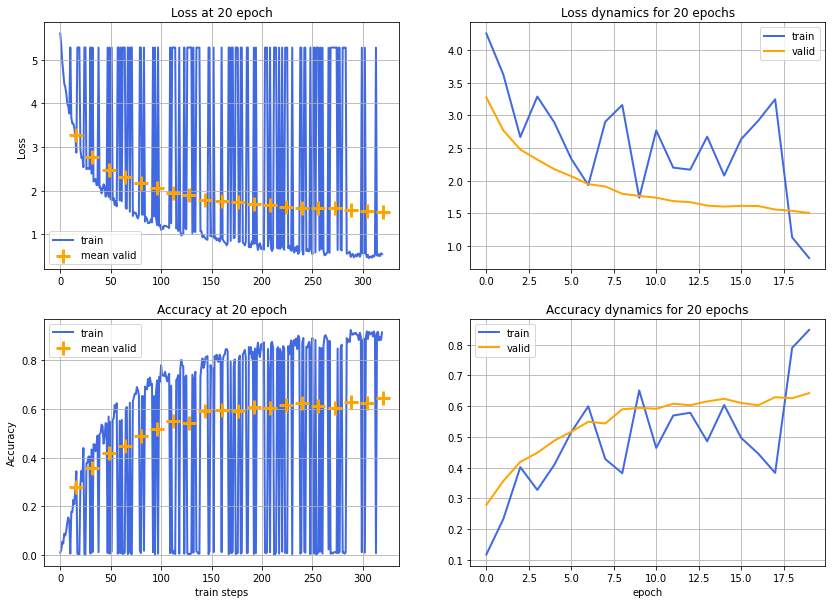

epoch: 100%|██████████| 20/20 [55:31<00:00, 166.58s/it]


Best valid accuracy: 0.6426


In [ ]:
if device != torch.device(type='cpu'):
    torch.cuda.empty_cache()
# head training
model = train(model, criterion, optimizer, scheduler, num_epochs=20, device=device, use_scaler=True, saveto=save_path + folder)

In [ ]:
if device != 'cpu':
    torch.cuda.empty_cache()
acc1 = eval(model, device)
print(f'\nTest accuracy: {acc1 * 100:.4f}%')

batch: 100%|██████████| 16/16 [01:31<00:00,  5.69s/it]



Test accuracy: 64.3204%


In [ ]:
model.load_state_dict(torch.load(f='/content/drive/MyDrive/ConvNeXt-standard/ConvNeXt-20.pth', map_location=device))

<All keys matched successfully>

Дообучим последнюю стадию и голову с маленьким `lr` на 30 эпох.

In [ ]:
for parameters in model.stages[3].parameters():
    parameters.requires_grad = True

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-8, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

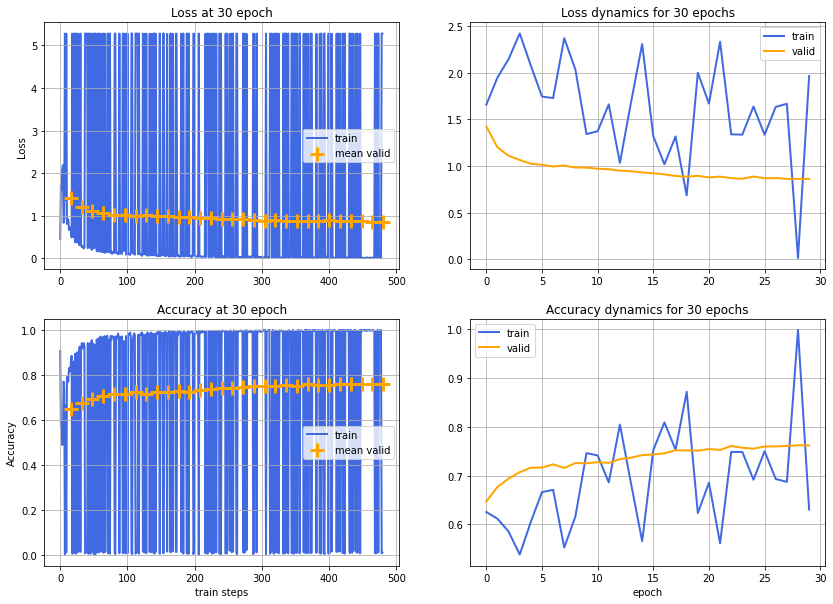

epoch: 100%|██████████| 30/30 [1:24:07<00:00, 168.27s/it]


Best valid accuracy: 0.7620


In [ ]:
if device != torch.device(type='cpu'):
    torch.cuda.empty_cache()
# head + last stage training
model = train(model, criterion, optimizer, scheduler, num_epochs=30, device=device, use_scaler=True, saveto=save_path + folder)

In [ ]:
if device != 'cpu':
    torch.cuda.empty_cache()
acc3 = eval(model, device)
print(f'\nTest accuracy: {acc3 * 100:.4f}%')

batch: 100%|██████████| 16/16 [01:30<00:00,  5.67s/it]



Test accuracy: 76.1970%


In [ ]:
model.load_state_dict(torch.load(f='/content/drive/MyDrive/ConvNeXt-standard/ConvNeXt-30.pth', map_location=device))

<All keys matched successfully>

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

24222

Здесь значение `accuracy` составило 76.1970%.

# Advances Augmentations

Теперь посмотрим, помогут ли предложенные авторами аугментации обучиться лучше.

[Augments](https://timm.fast.ai/mixup_cutmix):
* Mixup
* Cutmix
* RandomErasing
* RandAugment

Другие регуляризации:
* Label Smoothing
* Stochastic Depth

## Data

In [ ]:
from timm.data.mixup import Mixup
from timm.data.random_erasing import RandomErasing
from timm.data.auto_augment import rand_augment_transform
from PIL import Image

# parameters are from paper's A2 appendix
mix_args = {
    'mixup_alpha': 0.8,
    'cutmix_alpha': 1.,
    'cutmix_minmax': None,
    'prob': 0.5,
    'switch_prob': 0.5,
    'mode': 'batch',
    'label_smoothing': 0.1,
    'num_classes': 196,
}

# https://github.com/rwightman/pytorch-image-models/blob/master/timm/data/mixup.py
mix_fn = Mixup(**mix_args)

erasing_fn = RandomErasing(probability=0.25, mode='pixel', device='cpu')

randaug_fn = rand_augment_transform(
    config_str='rand-m9-mstd0.5', 
    hparams={'translate_const': 117, 'img_mean': (124, 116, 104)}
)

In [ ]:
train_transform = transforms.Compose([*base_transforms[:2], randaug_fn,  #  <-
                                      *base_transforms[2:], erasing_fn,
                                    ])

valid_transform = transforms.Compose(base_transforms)

In [ ]:
train_dataset = StanfordCars(root='data', split='train', transform=train_transform)
valid_dataset = StanfordCars(root='data', split='test', transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

dataloaders = { 'train': train_loader, 'valid': valid_loader }
dataset_sizes = { 'train': len(train_dataset), 'valid': len(valid_dataset) }

In [ ]:
def imshow_mix(inputs, classes, mix_fn):
    inputs_, classes_ = mix_fn(inputs, classes)
    classes_ = classes_.argmax(dim=-1)
    out = torchvision.utils.make_grid(inputs_[:8])
    imshow(out, title=classes_[:8].tolist())


# def imshow_erasing(inputs, classes, erasing_fn):
#     inputs_ = erasing_fn(inputs)
#     out = torchvision.utils.make_grid(inputs_[:8])
#     imshow(out, title=classes[:8].tolist())


# def imshow_randaug(inputs, classes, randaug_fn):
#     inputs_ = randaug_fn(inputs)
#     out = torchvision.utils.make_grid(inputs_[:8])
#     imshow(out, title=classes[:8].tolist())

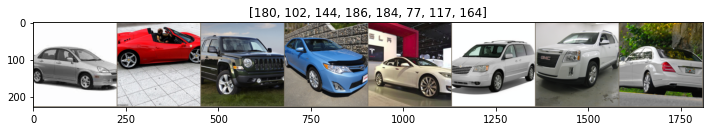

In [ ]:
inputs, classes = next(iter(valid_loader))
imshow_base(inputs, classes)

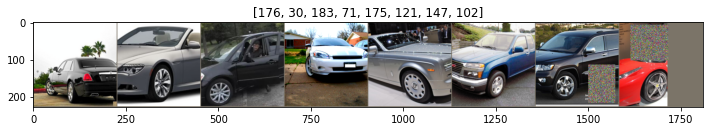

In [ ]:
inputs, classes = next(iter(train_loader))
imshow_base(inputs, classes)

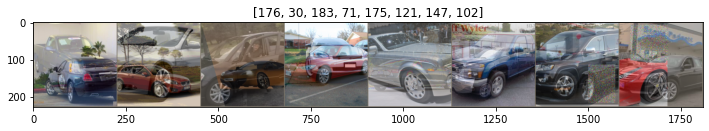

In [ ]:
imshow_mix(inputs, classes, mix_fn)

## Train

In [ ]:
model = get_convnext('convnext_tiny_in22k')
folder = 'ConvNeXt-advanced/'

try:
    os.mkdir(save_path + folder)
except:
    pass

Процедура обучения -- идентичная.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.NLLLoss()
# params from paper's A2 appendix
optimizer = optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-8, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

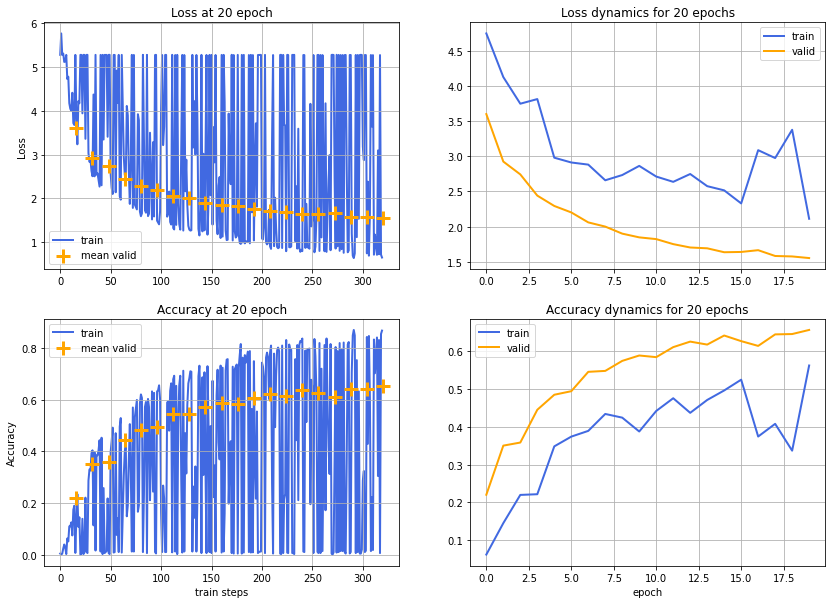

epoch: 100%|██████████| 20/20 [59:23<00:00, 178.18s/it]


Best valid accuracy: 0.6543


In [ ]:
if device != torch.device(type='cpu'):
    torch.cuda.empty_cache()
model = train(model, criterion, optimizer, scheduler, num_epochs=20, device=device, use_scaler=True, mix_fn=mix_fn, saveto=save_path + folder)

In [ ]:
if device != torch.device(type='cpu'):
    torch.cuda.empty_cache()
acc4 = eval(model, device)
print(f'\nTest accuracy: {acc4 * 100:.4f}%')

batch: 100%|██████████| 16/16 [01:28<00:00,  5.54s/it]



Test accuracy: 65.4894%


In [ ]:
for parameters in model.stages[3].parameters():
    parameters.requires_grad = True

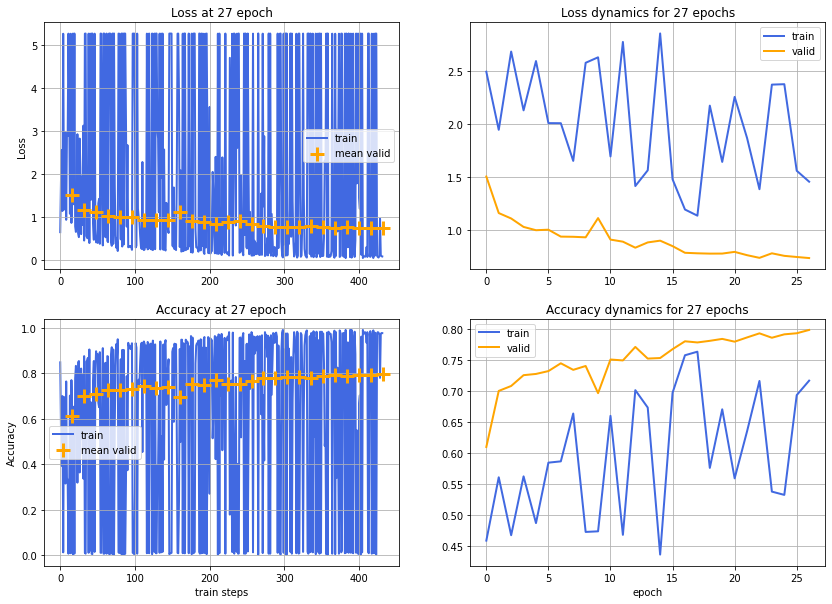

epoch:  90%|█████████ | 27/30 [1:20:48<08:57, 179.12s/it]


Phase: train running
train loss: 1.6815 Acc: 0.6633
Done in 1.9189 m

Phase: valid running


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-8, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

if device != torch.device(type='cpu'):
    torch.cuda.empty_cache()
model = train(model, criterion, optimizer, scheduler, num_epochs=30, device=device, use_scaler=True, mix_fn=mix_fn, saveto=save_path + folder)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = get_convnext('convnext_tiny_in22k').to(device)
model.load_state_dict(torch.load(f='/content/drive/MyDrive/ConvNeXt-advanced/ConvNeXt-30.pth', map_location=device))

<All keys matched successfully>

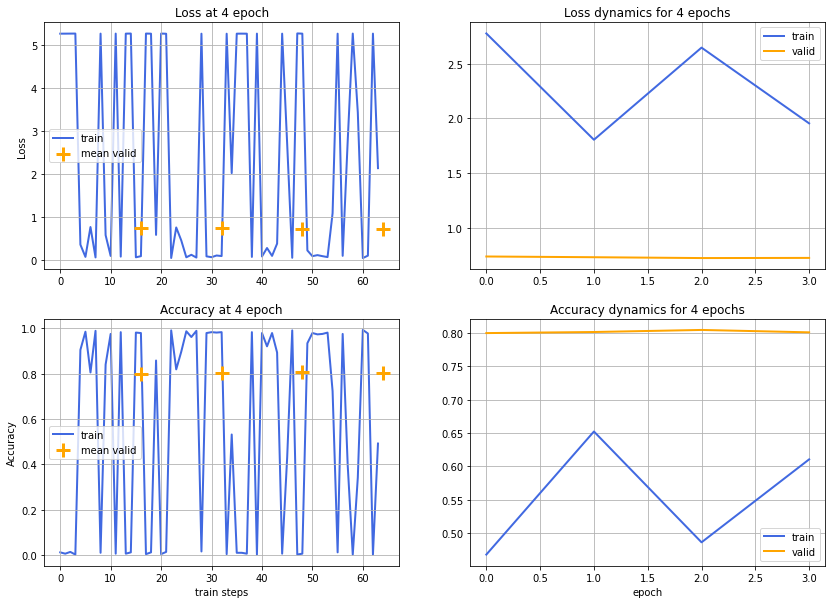

epoch: 100%|██████████| 4/4 [11:44<00:00, 176.16s/it]


Best valid accuracy: 0.8049


In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-8, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

if device != torch.device(type='cpu'):
    torch.cuda.empty_cache()
model = train(model, criterion, optimizer, scheduler, num_epochs=4, device=device, use_scaler=True, mix_fn=mix_fn, saveto=save_path + folder)

In [ ]:
if device != torch.device(type='cpu'):
    torch.cuda.empty_cache()
acc5 = eval(model, device)
print(f'\nTest accuracy: {acc5 * 100:.4f}%')

batch: 100%|██████████| 16/16 [01:24<00:00,  5.27s/it]



Test accuracy: 80.4999%


# Результаты и выводы

Модель неплохо работает на выбранной задаче, однако для достижения хорошего качества требуется достаточно много эпох. Так, авторы статьи дообучали модель на ImageNet1k и ImageNet22k на 30 эпох, нам же потребовалось суммарно 50 эпох и разбиение тюнинга на две стадии.

Регуляризации, предложенные в статье показывают отличные результаты. Так, при абсолютно той же процедуре обучения и при одинаковых гиперпараметров разница по `accuracy` составила **4.3%** (76.2% против 80.5%), что является весомым аргументом в пользу выбора таких регуляризаций.

**[!]** Стоит отметить, что при дообучении авторы работы **не использовали** `cutmix` и `mixup` аугментации.

Модель обучается достаточно быстро (менее 3 минут на эпоху) с использованием техники `mixed precision training` и `gradient scaling`. В обоих случаях процесс обучения в целом стабильный, однако и значение функции потерь, и значение метрики на трейне сильно колеблются.

![gif2](https://media.tenor.com/76XxFDBUu48AAAAC/frustrated-mad.gif)